In [1]:
using Turing
using Distributions
using BenchmarkTools
using Random
using Plots

┌ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
└ @ Base loading.jl:1278


## State Estimation in a Linear Gaussian State-space Model

In this demo, the goal is to smooth noisy observations by performing full inference with a state-space model (SSM).

We wil use the following model:

\begin{equation} \label{eq:linear_gaussian_ssm}
  \begin{aligned}
    \mathbf{x}_k & = \, \mathbf{A}\mathbf{x}_{k - 1} + \mathcal{P} \\
    \mathbf{y}_k & = \, \mathbf{B}\mathbf{x}_{k} + \mathcal{Q} \\
  \end{aligned}
\end{equation}
 
In this model, we denote by $\mathbf{x}_k$ the current state of the system (at time step $k$), by $\mathbf{x}_{k - 1}$ the previous state at time $k-1$, $\mathbf{A}$ and $\mathbf{B}$ are a constant system inputs and $\mathbf{y}_k$ is a noisy observation of $\mathbf{x}_k$. We further assume that the states and the observations are corrupted by i.i.d. Gaussian noise with variances $\mathcal{P}$ and $\mathcal{Q}$ respectively.

The SSM can be represented by the following factor graph, where the pictured section is chained over time:

<img src="pictures/ssm_model.eps" alt="Gaussian Linear State Space Model" style="width: 400px;"/>

In [2]:
@model LinearGaussianSSM(y, A, B, P, Q) = begin
    n = length(y)

    # State sequence.
    x = Vector(undef, n)

    # Observe each point of the input.
    x[1] ~ MvNormal([ 0.0, 0.0 ], 1e1)
    y[1] ~ MvNormal(B * x[1], Q)

    for t in 2:n
        x[t] ~ MvNormal(A * x[t - 1], P)
        y[t] ~ MvNormal(B * x[t], Q)
    end
end;

In [3]:
function generate_data(n, A, B, P, Q; seed)
    Random.seed!(seed)

    x_prev = zeros(2)

    x = Vector{Vector{Float64}}(undef, n)
    y = Vector{Vector{Float64}}(undef, n)

    for i in 1:n
        x[i] = rand(MvNormal(A * x_prev, P))
        y[i] = rand(MvNormal(B * x[i], Q))

        x_prev = x[i]
    end
   
    return x, y
end

generate_data (generic function with 1 method)

In [4]:
seed = 1234
n = 100
θ = π / 15
A = [ cos(θ) -sin(θ); sin(θ) cos(θ) ]
B = [ 1.3 0.0; 0.0 0.7 ]
P = [ 1.0 0.0; 0.0 1.0 ]
Q = [ 1.0 0.0; 0.0 1.0 ]

real_x, real_y = generate_data(n, A, B, P, Q, seed = seed);

In [5]:
function inference(observations, A, B, P, Q; nsamples = 500)
    return sample(LinearGaussianSSM(observations, A, B, P, Q), HMC(0.1, 5), nsamples)
end

inference (generic function with 1 method)

In [6]:
x_inferred = inference(real_y, A, B, P, Q, nsamples = 250);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:22


In [8]:
using JLD2

┌ Info: Precompiling JLD2 [033835bb-8acc-5ee8-8aae-3f567f8a3819]
└ @ Base loading.jl:1278


In [18]:
n = 100
JLD2.@save "example$(n).jld2" {compress=true} benchmark_results_500 = x_inferred

In [19]:
benchmark_results_nsamples500 = map([ 50, 100, 250, 500, 1000 ]) do size
    states, observations = generate_data(size, A, B, P, Q, seed = seed);
    result      = inference(observations, A, B, P, Q, nsamples = 500)
    benchmark   = @benchmark inference($observations, $A, $B, $P, $Q, nsamples = 500)
    benchmark_results = (size, states, observations, benchmark, result)
    JLD2.@save "benchmark_results_nsamples500_$(size).jld2" {compress=true} benchmark_results = benchmark_results
    println("Completed $(size)")
    return benchmark_results
end

JLD2.@save "benchmark_results_nsamples500.jld2" {compress=true} benchmark_results_nsamples500 = benchmark_results_nsamples500

println("Completed")

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:09
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:09
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:09
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:08
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:08


Completed 50


Sampling: 100%|█████████████████████████████████████████| Time: 0:00:36
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:35
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:36
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:34
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:34


Completed 100


Sampling: 100%|█████████████████████████████████████████| Time: 0:03:45
Sampling: 100%|█████████████████████████████████████████| Time: 0:03:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:03:51
Sampling: 100%|█████████████████████████████████████████| Time: 0:03:41
Sampling: 100%|█████████████████████████████████████████| Time: 0:03:41


Completed 250


Sampling: 100%|█████████████████████████████████████████| Time: 0:15:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:16:07
Sampling: 100%|█████████████████████████████████████████| Time: 0:15:07
Sampling: 100%|█████████████████████████████████████████| Time: 0:15:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:14:59


Completed 500


Sampling: 100%|█████████████████████████████████████████| Time: 1:01:03
Sampling: 100%|█████████████████████████████████████████| Time: 1:00:55
Sampling: 100%|█████████████████████████████████████████| Time: 1:01:15
Sampling: 100%|█████████████████████████████████████████| Time: 1:01:17
Sampling: 100%|█████████████████████████████████████████| Time: 1:01:07


Completed 1000
Completed


In [20]:
benchmark_results_nsamples1000 = map([ 50, 100, 250, 500, 1000 ]) do size
    states, observations = generate_data(size, A, B, P, Q, seed = seed);
    result      = inference(observations, A, B, P, Q, nsamples = 1000)
    benchmark   = @benchmark inference($observations, $A, $B, $P, $Q, nsamples = 1000)
    benchmark_results = (size, states, observations, benchmark, result)
    JLD2.@save "benchmark_results_nsamples1000_$(size).jld2" {compress=true} benchmark_results = benchmark_results
    println("Completed $(size)")
    return benchmark_results
end

JLD2.@save "benchmark_results_nsamples1000.jld2" {compress=true} benchmark_results_nsamples1000 = benchmark_results_nsamples1000

println("Completed")

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:18
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:18
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:19
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:17
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:17


Completed 50


Sampling: 100%|█████████████████████████████████████████| Time: 0:01:11
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:13
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:14
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:11
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:10


Completed 100


Sampling: 100%|█████████████████████████████████████████| Time: 0:07:38
Sampling: 100%|█████████████████████████████████████████| Time: 0:07:45
Sampling: 100%|█████████████████████████████████████████| Time: 0:07:30
Sampling: 100%|█████████████████████████████████████████| Time: 0:07:32
Sampling: 100%|█████████████████████████████████████████| Time: 0:07:32


Completed 250


Sampling: 100%|█████████████████████████████████████████| Time: 0:30:54
Sampling: 100%|█████████████████████████████████████████| Time: 0:31:46
Sampling: 100%|█████████████████████████████████████████| Time: 0:32:49
Sampling: 100%|█████████████████████████████████████████| Time: 0:30:23
Sampling: 100%|█████████████████████████████████████████| Time: 0:30:26


Completed 500


Sampling: 100%|█████████████████████████████████████████| Time: 2:05:14
Sampling: 100%|█████████████████████████████████████████| Time: 2:03:45
Sampling: 100%|█████████████████████████████████████████| Time: 2:09:34
Sampling: 100%|█████████████████████████████████████████| Time: 2:15:11
Sampling: 100%|█████████████████████████████████████████| Time: 2:18:17


Completed 1000
Completed


In [64]:
-benchmark_results_nsamples500[2][5]["log_density"][end]

555.6349017819692

In [65]:
-benchmark_results_nsamples5=1000[2][5]["log_density"][end]

LoadError: [91merror in method definition: function Base.- must be explicitly imported to be extended[39m

In [58]:
_benchmark = benchmark_results_nsamples500[2]

samples = get(_benchmark[5], :x);
n = _benchmark[1]
real_x = _benchmark[2]
real_y = _benchmark[3];

In [59]:
mx = [mean(samples.x[i].data) for i in 1:2n]
vx = [std(samples.x[i].data) for i in 1:2n]
;

In [60]:
reshape_data(data) = transpose(reduce(hcat, data))
reshape_turing_data(data) = transpose(reshape(data, (2, Int(length(data) / 2))))

reshape_turing_data (generic function with 1 method)

In [61]:
using PGFPlotsX

PGFPlotsX.latexengine!(PGFPlotsX.PDFLATEX)

pgfplotsx();

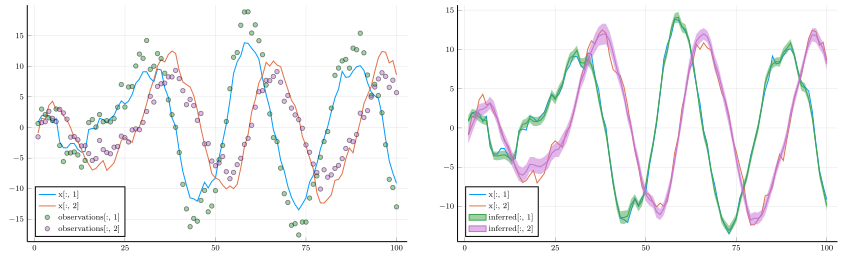

In [62]:
generated_data = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
generated_data = plot!(1:n, real_y |> reshape_data, seriestype = :scatter, ms = 3, alpha = 0.5, label = [ "observations[:, 1]" "observations[:, 2]" ])
generated_data = plot!(generated_data, legend = :bottomleft)

results_plot = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
results_plot = plot!(results_plot, 1:n, mx |> reshape_turing_data, ribbon = vx |> reshape_turing_data, label = [ "inferred[:, 1]" "inferred[:, 2]" ])
results_plot = plot!(results_plot, legend = :bottomleft)

plot(generated_data, results_plot, size = (1200, 400))

In [253]:
savefig(generated_data, "./plots/linear_gaussian_ssm_smoothing_turing_data.tikz")
savefig(results_plot, "./plots/linear_gaussian_ssm_smoothing_turing_inference.tikz")

In [94]:
@benchmark inference($real_y, $A, $B, $P, $Q)

BenchmarkTools.Trial: 
  memory estimate:  6.93 GiB
  allocs estimate:  63239883
  --------------
  minimum time:     22.330 s (12.06% GC)
  median time:      22.330 s (12.06% GC)
  mean time:        22.330 s (12.06% GC)
  maximum time:     22.330 s (12.06% GC)
  --------------
  samples:          1
  evals/sample:     1

In [95]:
import Pkg; Pkg.status(); versioninfo()

Status `~/Projects/Overleaf/RMP_Experiments/Project.toml`
  [6e4b80f9] BenchmarkTools v0.5.0
  [31c24e10] Distributions v0.24.12
  [b3f8163a] GraphPPL v0.1.0 `~/.julia/dev/GraphPPL.jl`
  [6218d12a] ImageMagick v1.1.6
  [91a5bcdd] Plots v1.10.4
  [a194aa59] ReactiveMP v0.5.0 `~/.julia/dev/ReactiveMP`
  [df971d30] Rocket v1.3.4 `~/.julia/dev/Rocket`
  [fce5fe82] Turing v0.15.10
Julia Version 1.5.3
Commit 788b2c77c1 (2020-11-09 13:37 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)
